In [1]:
import pandas as pd
import time

import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,Callback
import pandas as pd
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from funciones import *
from tensorflow.keras.models import load_model,model_from_json
import os

2023-05-17 15:17:51.298172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 15:17:52.142322: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64
2023-05-17 15:17:52.142436: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64
2023-05-17 15:

In [2]:
tf.config.experimental.enable_op_determinism()


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True )
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))


cuda_malloc_async


In [4]:
#datos_norm = cargar_dataset()
datos_norm = cargar_datasetOtherStations()
datos_norm['week_cos'] =  np.cos(2 * np.pi * datos_norm.index.isocalendar().week / 53)
datos_norm['week_sin'] =  np.sin(2 * np.pi * datos_norm.index.isocalendar().week / 53)
horizonte = 28
tamanio_ventana=545
cantidad_unidades=60
tamanio_batch=60 
dropout=0.250393
features_set=3
year_ini=73
arch='LSTM'# cambiar tambien el elemento
modelo=arch+'_h'+str(horizonte)+'_w'+str(tamanio_ventana)+'_u'+str(cantidad_unidades)
modelo+='_d'+str(dropout)
modelo+='_f'+str(features_set)
modelo+='_y'+str(year_ini)

datos_norm = cargar_datasetOtherStations()
datos_norm['week_cos'] =  np.cos(2 * np.pi * datos_norm.index.isocalendar().week / 53)
datos_norm['week_sin'] =  np.sin(2 * np.pi * datos_norm.index.isocalendar().week / 53)
horizonte = 28
tamanio_ventana=365
cantidad_unidades=15
epocas=50
tamanio_batch=15 
dropout=0.125727 
features_set=3
year_ini=78
arch='LSTM'# cambiar tambien el elemento
modelo=arch+'_h'+str(horizonte)+'_w'+str(tamanio_ventana)+'_u'+str(cantidad_unidades)
modelo+='_d'+str(dropout)
modelo+='_f'+str(features_set)
modelo+='_y'+str(year_ini)

horizonte = 28
tamanio_ventana=365
cantidad_unidades=15
epocas=50
tamanio_batch=60 
dropout=0.308244 
features_set=2
year_ini=83
arch='LSTM'# cambiar tambien el elemento
modelo=arch+'_h'+str(horizonte)+'_w'+str(tamanio_ventana)+'_u'+str(cantidad_unidades)
modelo+='_d'+str(dropout)
modelo+='_f'+str(features_set)
modelo+='_y'+str(year_ini)

In [5]:
#lista=[['nivel'],['nivel','week_cos','week_sin'],['nivel','week_cos','week_sin','valor010' , 'valor088' , 'valor134' , 'valor183' , 'valor211']]
lista=[['nivel'],['nivel','week_cos','week_sin'],['nivel','week_cos','week_sin' ,  'valor134' , 'valor183' , 'valor211'],['nivel','week_cos','week_sin','valor010' , 'valor134' , 'valor183' , 'valor211']]
seed = 42
        

tf.random.set_seed(seed)
np.random.seed(seed)
datos_normm=datos_norm[lista[features_set]]
nfeatures=len(datos_normm.columns)
desde=(dt.datetime.strptime('19'+str(year_ini)+'-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
train = datos_normm.loc[desde:'2013-12-31']
ix=train.index
trainScaler = MinMaxScaler(feature_range=(0, 1))
trainScaler.fit(train)
trainScaled = pd.DataFrame(trainScaler.transform(train),columns=train.columns)
trainScaled.set_index(ix)

x_train, y_train=preparar_datos(tamanio_ventana,horizonte, trainScaled)

desde=(dt.datetime.strptime('2014-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
val = datos_normm.loc[desde:'2017-12-31']
ix=val.index
valScaler = MinMaxScaler(feature_range=(0, 1))
valScaler.fit(val)
valScaled = pd.DataFrame(valScaler.transform(val),columns=val.columns)
valScaled.set_index(ix)
x_val, y_val=preparar_datos(tamanio_ventana,horizonte, valScaled)



<Axes: xlabel='fecha'>

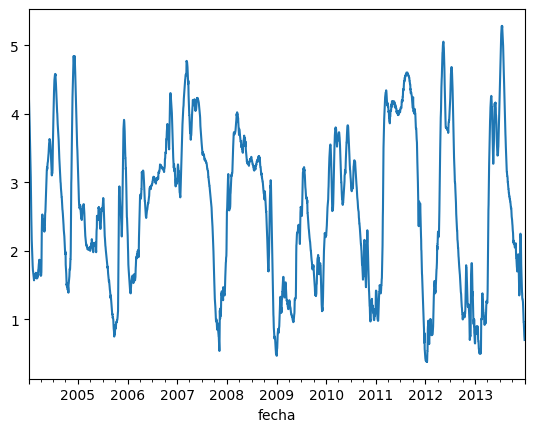

In [6]:
train['nivel'][-3650:].plot()

In [7]:
from statsmodels.tsa.stattools import adfuller
X=train['nivel'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.011647
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [8]:

model = keras.Sequential()
model.add( tf.keras.layers.LSTM( cantidad_unidades, input_shape=(tamanio_ventana, nfeatures)))
model.add( tf.keras.layers.Dropout(rate=dropout))
model.add(tf.keras.layers.Dense(horizonte))

def exponential_decay_weights(seq_length, decay_factor):
    weights = np.exp(-decay_factor * np.arange(seq_length))
    return weights / np.sum(weights)  # Normalize weights to sum up to 1

def multi_step_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    seq_length = 28  # Length of the time series
    decay_factor = -0.05  # Controls the rate of decay
    weights = tf.constant(exponential_decay_weights(seq_length, decay_factor), dtype=tf.float32)
    squared_diff = tf.square(y_true - y_pred)
    weighted_squared_diff = tf.math.multiply(squared_diff, tf.expand_dims(weights, axis=-1))
    mse= tf.reduce_mean(weighted_squared_diff )

    num_steps = 28  # Number of steps in each prediction
    adjusted_loss = mse / num_steps
    return adjusted_loss

   
model.compile(optimizer=keras.optimizers.Adam(0.001), loss=multi_step_loss,metrics=[RootMeanSquaredError()])

  
model_json = model.to_json() 
with open("modelos/model"+modelo+".json", "w") as json_file:
        json_file.write(model_json)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                16320     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 28)                1708      
                                                                 
Total params: 18,028
Trainable params: 18,028
Non-trainable params: 0
_________________________________________________________________


In [10]:
start_time = time.time()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
initial_learning_rate=0.0005
def lr_step_decay(epoch, lr):
    drop = 0.5  
    epochs_drop = 10 
    lr = initial_learning_rate * (drop ** (epoch // epochs_drop))
    return lr
        
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)
epocas=200
callbacks_list = [early_stopping,lr_scheduler ]

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epocas, shuffle=False,batch_size=tamanio_batch, verbose=1, callbacks=[callbacks_list])
Y_prediction = valScaler.inverse_transform(np.hstack(((model.predict(x_val).reshape(-1, 1), np.zeros((np.size(y_val),nfeatures -1))))))[:, 0]
y_val_inv=valScaler.inverse_transform(np.hstack(((y_val.reshape(-1, 1), np.zeros((np.size(y_val),nfeatures -1))))))[:, 0]
        
mse=mean_squared_error( y_val_inv, Y_prediction)
rmse=np.sqrt(mse)
maxError_=max_error(y_val_inv, Y_prediction)
r2_=r2_score(y_val_inv, Y_prediction)
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  ))
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  ))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time step : {elapsed_time:.6f} seconds")

Epoch 1/200
250/250 [==============================] - 14s 41ms/step - loss: 6.4540e-05 - root_mean_squared_error: 0.2249 - val_loss: 4.4245e-05 - val_root_mean_squared_error: 0.1862 - lr: 5.0000e-04
Epoch 2/200
250/250 [==============================] - 10s 39ms/step - loss: 1.8500e-05 - root_mean_squared_error: 0.1204 - val_loss: 3.0683e-05 - val_root_mean_squared_error: 0.1551 - lr: 5.0000e-04
Epoch 3/200
250/250 [==============================] - 9s 37ms/step - loss: 1.3439e-05 - root_mean_squared_error: 0.1026 - val_loss: 2.4222e-05 - val_root_mean_squared_error: 0.1378 - lr: 5.0000e-04
Epoch 4/200
250/250 [==============================] - 9s 34ms/step - loss: 1.0951e-05 - root_mean_squared_error: 0.0927 - val_loss: 2.0968e-05 - val_root_mean_squared_error: 0.1282 - lr: 5.0000e-04
Epoch 5/200
250/250 [==============================] - 10s 39ms/step - loss: 9.4240e-06 - root_mean_squared_error: 0.0860 - val_loss: 1.8262e-05 - val_root_mean_squared_error: 0.1197 - lr: 5.0000e-04
Ep

In [44]:

model.save_weights("modelos/model"+modelo+".h5")

In [14]:
Y_prediction = valScaler.inverse_transform(np.hstack(((model.predict(x_val).reshape(-1, 1), np.zeros((np.size(y_val),nfeatures -1))))))[:, 0]
y_val_inv=valScaler.inverse_transform(np.hstack(((y_val.reshape(-1, 1), np.zeros((np.size(y_val),nfeatures -1))))))[:, 0]
        
mse=mean_squared_error( y_val_inv, Y_prediction)
rmse=np.sqrt(mse)
maxError_=max_error(y_val_inv, Y_prediction)
r2_=r2_score(y_val_inv, Y_prediction)
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  ))
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  ))


45/45 [==============================] - 1s 16ms/step
MSE: 0.4253853239935306 RMSE:0.6522157035778352
MaxError: 3.7670593905448913 R2:0.8483404074345084


In [15]:
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates
from matplotlib import dates as mdates

json_file = open("modelos/model"+modelo+".json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("modelos/model"+modelo+".h5")
print("Loaded model from disk")
val=load(open('modelos/val.pkl', 'rb'))

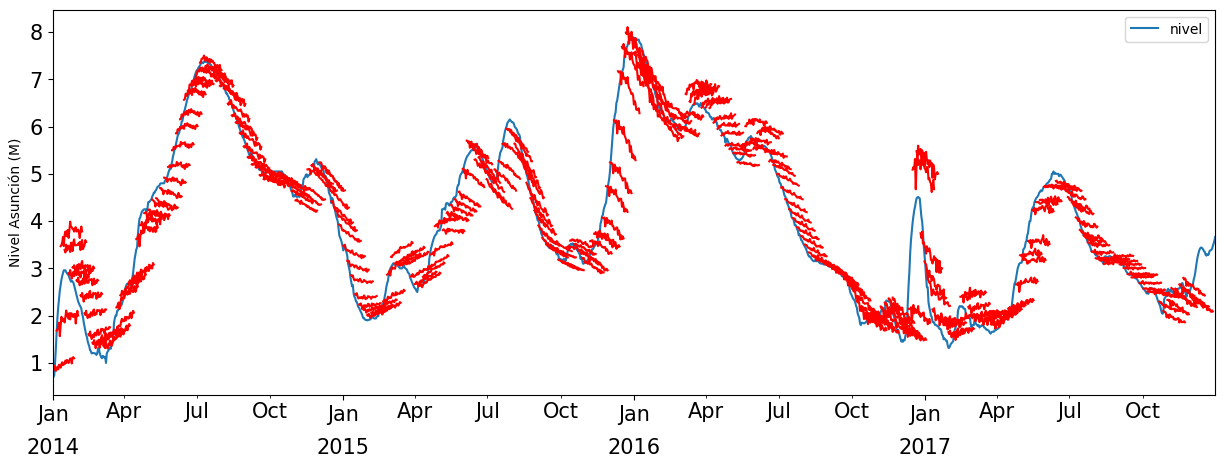

In [16]:
if True:
    df=val[['nivel']][ tamanio_ventana:]


    f, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(data =df,ax=ax)
    fmt_month = mdates.MonthLocator(interval=3)
    # Minor ticks every year.
    fmt_year = mdates.YearLocator()

    ax.xaxis.set_minor_locator(fmt_month)
    # '%b' to get the names of the month
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(fmt_year)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    # fontsize for month labels
    ax.tick_params(labelsize=15, which='both')
    # create a second x-axis beneath the first x-axis to show the year in YYYY format
    sec_xaxis = ax.secondary_xaxis(-0.1)
    sec_xaxis.xaxis.set_major_locator(fmt_year)
    sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide the second x-axis spines and ticks
    sec_xaxis.spines['bottom'].set_visible(False)
    sec_xaxis.tick_params(length=0, labelsize=15)

    ax.set_ylabel('Nivel Asunción (M)')
    ax.set_xlabel('')

    ax.set_xlim(df.index[0],df.index[-1])
    j=0
    mse=[]
    maxe=[]
    t=[]
    for i in range(0, len(Y_prediction),horizonte):
        if(j%5==0 and (j+horizonte)<len(df)):
            mse.append(mean_squared_error(np.array(df.nivel[j:(j+horizonte)]), Y_prediction[i:i+horizonte]))
            maxe.append(max_error(np.array(df.nivel[j:(j+horizonte)]), Y_prediction[i:i+horizonte]))
            t.append(df.index[j])

            plt.plot(df.index[j:(j+horizonte)], Y_prediction[i:i+horizonte], color='red')
        j=j+1                                          

    plt.show()

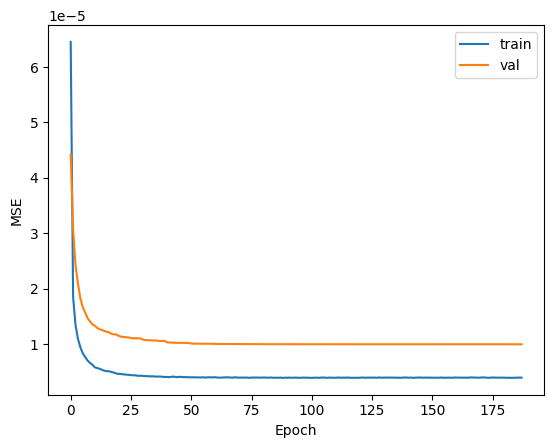

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [16]:
from pickle import dump,load

dump(val, open('modelos/val.pkl', 'wb'))
dump(Y_prediction, open('modelos/valpred'+modelo+'.pkl', 'wb'))

In [20]:
#lista=[['nivel'],['nivel','week_cos','week_sin'],['nivel','week_cos','week_sin','valor010' , 'valor088' , 'valor134' , 'valor183' , 'valor211']]
lista=[['nivel'],['nivel','week_cos','week_sin'],['nivel','week_cos','week_sin' ,  'valor134' , 'valor183' , 'valor211'],['nivel','week_cos','week_sin','valor010' , 'valor134' , 'valor183' , 'valor211']]

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
datos_normm=datos_norm[lista[features_set]]
nfeatures=len(datos_normm.columns)
desde=(dt.datetime.strptime('19'+str(year_ini)+'-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
train = datos_normm.loc[desde:'2017-12-31']
ix=train.index
trainScaler = MinMaxScaler(feature_range=(0, 1))
trainScaler.fit(train)
trainScaled = pd.DataFrame(trainScaler.transform(train),columns=train.columns)
trainScaled.set_index(ix)
x_train, y_train=preparar_datos(tamanio_ventana,horizonte, trainScaled)

desde=(dt.datetime.strptime('2018-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
test = datos_normm.loc[desde:'2022-12-31']
ix=test.index
testScaler = MinMaxScaler(feature_range=(0, 1))
testScaler.fit(train)
testScaled = pd.DataFrame(testScaler.transform(test),columns=test.columns)
testScaled.set_index(ix)
x_test, y_test=preparar_datos(tamanio_ventana,horizonte, testScaled)


In [21]:


model = keras.Sequential()
model.add( tf.keras.layers.LSTM( cantidad_unidades, input_shape=(tamanio_ventana, nfeatures)))
model.add( tf.keras.layers.Dropout(rate=dropout))
model.add(tf.keras.layers.Dense(horizonte))
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mean_absolute_error',metrics=[RootMeanSquaredError()])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60)                16320     
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 28)                1708      
                                                                 
Total params: 18,028
Trainable params: 18,028
Non-trainable params: 0
_________________________________________________________________


In [22]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
initial_learning_rate=0.0005
def lr_step_decay(epoch, lr):
    drop = 0.5  # Factor by which the learning rate will be reduced
    epochs_drop = 10  # Number of epochs after which to apply the drop

    # Compute the updated learning rate for the current epoch
    lr = initial_learning_rate * (drop ** (epoch // epochs_drop))

    return lr     
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)
epocas=200

callbacks_list = [early_stopping,lr_scheduler ]
        
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=epocas, batch_size=int(tamanio_batch/2),shuffle=False, verbose=1,callbacks=[callbacks_list])


Epoch 1/200
547/547 [==============================] - 24s 40ms/step - loss: 0.1151 - root_mean_squared_error: 0.1552 - val_loss: 0.0876 - val_root_mean_squared_error: 0.1099 - lr: 5.0000e-04
Epoch 2/200
547/547 [==============================] - 19s 36ms/step - loss: 0.0711 - root_mean_squared_error: 0.0936 - val_loss: 0.0740 - val_root_mean_squared_error: 0.0955 - lr: 5.0000e-04
Epoch 3/200
547/547 [==============================] - 20s 36ms/step - loss: 0.0603 - root_mean_squared_error: 0.0801 - val_loss: 0.0659 - val_root_mean_squared_error: 0.0874 - lr: 5.0000e-04
Epoch 4/200
547/547 [==============================] - 20s 36ms/step - loss: 0.0549 - root_mean_squared_error: 0.0734 - val_loss: 0.0623 - val_root_mean_squared_error: 0.0841 - lr: 5.0000e-04
Epoch 5/200
547/547 [==============================] - 20s 36ms/step - loss: 0.0511 - root_mean_squared_error: 0.0689 - val_loss: 0.0608 - val_root_mean_squared_error: 0.0822 - lr: 5.0000e-04
Epoch 6/200
547/547 [===================

In [23]:
model.save_weights("modelos/model"+modelo+"final.h5")


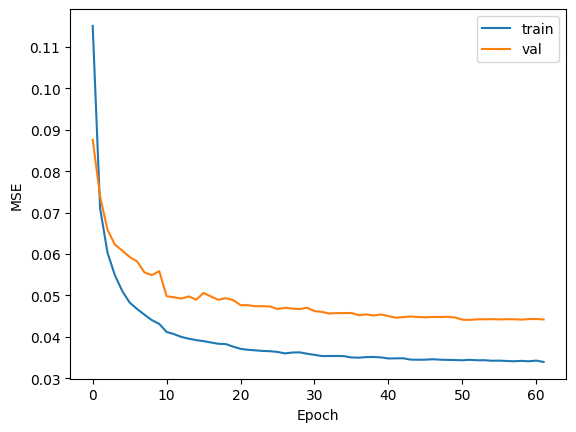

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

In [25]:
Y_prediction =testScaler.inverse_transform(np.hstack(((model.predict(x_test).reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0]
y_test_inv=testScaler.inverse_transform(np.hstack(((y_test.reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0]
        
mse=mean_squared_error( y_test_inv, Y_prediction)
rmse=np.sqrt(mse)
maxError_=max_error(y_test_inv, Y_prediction)
r2_=r2_score(y_test_inv, Y_prediction)
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  ))
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  ))


57/57 [==============================] - 1s 15ms/step
MSE: 0.3641135757584678 RMSE:0.603418242812121
MaxError: 4.200219712853431 R2:0.9172785486296223


In [26]:
from pickle import dump,load

dump(test, open('modelos/test.pkl', 'wb'))
dump(Y_prediction, open('modelos/testpred'+modelo+'.pkl', 'wb'))

In [27]:
modelo

'LSTM_h28_w545_u60_d0.250393_f3_y73'

if True:
    df=test[['nivel']][ tamanio_ventana:]


    f, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(data =df,ax=ax)
    fmt_month = mdates.MonthLocator(interval=3)
    # Minor ticks every year.
    fmt_year = mdates.YearLocator()

    ax.xaxis.set_minor_locator(fmt_month)
    # '%b' to get the names of the month
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(fmt_year)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    # fontsize for month labels
    ax.tick_params(labelsize=15, which='both')
    # create a second x-axis beneath the first x-axis to show the year in YYYY format
    sec_xaxis = ax.secondary_xaxis(-0.1)
    sec_xaxis.xaxis.set_major_locator(fmt_year)
    sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide the second x-axis spines and ticks
    sec_xaxis.spines['bottom'].set_visible(False)
    sec_xaxis.tick_params(length=0, labelsize=15)

    ax.set_ylabel('Nivel Asunción (M)')
    ax.set_xlabel('')

    ax.set_xlim(df.index[0],df.index[-1])
    plt.plot(df.index[:len(Y_prediction)], Y_prediction, color='red')
    
    plt.show()

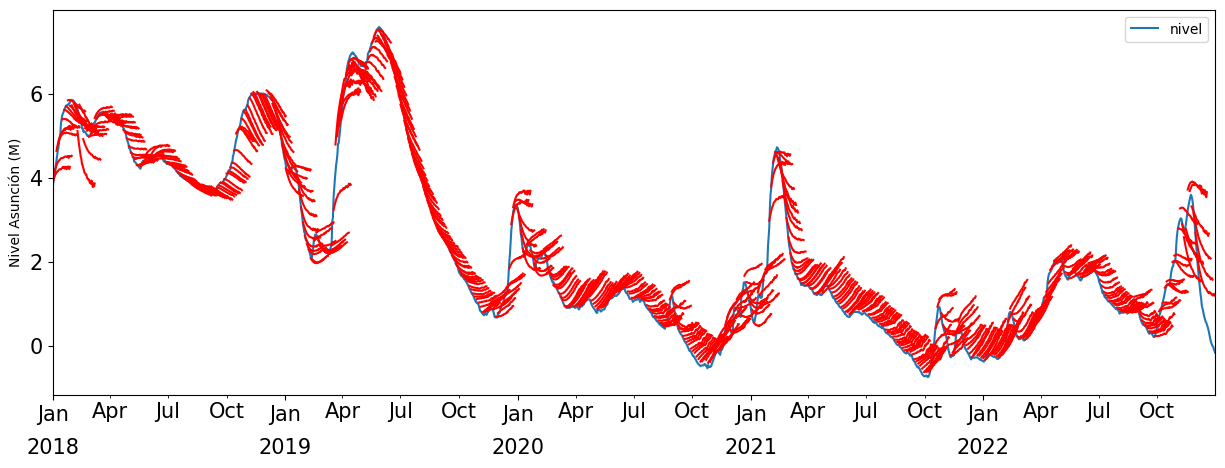

In [29]:
if True:
    df=test[['nivel']][ tamanio_ventana:]


    f, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(data =df,ax=ax)
    fmt_month = mdates.MonthLocator(interval=3)
    # Minor ticks every year.
    fmt_year = mdates.YearLocator()

    ax.xaxis.set_minor_locator(fmt_month)
    # '%b' to get the names of the month
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(fmt_year)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    # fontsize for month labels
    ax.tick_params(labelsize=15, which='both')
    # create a second x-axis beneath the first x-axis to show the year in YYYY format
    sec_xaxis = ax.secondary_xaxis(-0.1)
    sec_xaxis.xaxis.set_major_locator(fmt_year)
    sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide the second x-axis spines and ticks
    sec_xaxis.spines['bottom'].set_visible(False)
    sec_xaxis.tick_params(length=0, labelsize=15)

    ax.set_ylabel('Nivel Asunción (M)')
    ax.set_xlabel('')

    ax.set_xlim(df.index[0],df.index[-1])
    j=0
    mse=[]
    maxe=[]
    t=[]
    for i in range(0, len(Y_prediction),horizonte):
        if(j%3==0 and (j+horizonte)<len(df)):
            mse.append(mean_squared_error(np.array(df.nivel[j:(j+horizonte)]), Y_prediction[i:i+horizonte]))
            maxe.append(max_error(np.array(df.nivel[j:(j+horizonte)]), Y_prediction[i:i+horizonte]))
            t.append(df.index[j])

            plt.plot(df.index[j:(j+horizonte)], Y_prediction[i:i+horizonte], color='red')
        j=j+1                                          

    plt.show()